# Sandbox

This notebook answers question 3.4 form the text book Advances in Financial Machine Learning.

3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [1, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {-1, 1}.

I took some liberties by extending the features to which I use to build the meta model. I also add some performance metrics at the end. 

In conclusion: Meta Labeling works, SMA strategies suck.

In [1]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml

In [2]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [3]:
# Read in data
data = pd.read_csv('dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [4]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499


---
### Fit a Primary Model: Trend Following
Based on the simple moving average cross-over strategy.


In [5]:
# compute moving averages
fast_window = 20
slow_window = 50

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
data.head()

# Compute sides
data['side'] = np.nan

long_signals = data['fast_mavg'] >= data['slow_mavg'] 
short_signals = data['fast_mavg'] < data['slow_mavg'] 
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

In [6]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [7]:
data['side'].value_counts()

 1.0    45765
-1.0    39516
Name: side, dtype: int64

### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [8]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2011-09-01':'2018-01-01'].mean()*0.5)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [9]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

/home/jackal08/Git/mlfinlab/mlfinlab/labeling/labeling.py:122: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-07-15 17:27:02.294982 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


In [10]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

-1.0    4753
 1.0    4304
Name: side, dtype: int64

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [11]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5273
           1       0.42      1.00      0.59      3784

   micro avg       0.42      0.42      0.42      9057
   macro avg       0.21      0.50      0.29      9057
weighted avg       0.17      0.42      0.25      9057

Confusion Matrix
[[   0 5273]
 [   0 3784]]

Accuracy
0.4177983879871922


/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**A few takeaways**
* There is an imbalance in the classes - more are classified as "no trade"
* Meta-labeling says that there are many false-positives  
* the sklearn's confusion matrix is [[TN, FP][FN, TP]] 

---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [12]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115,NaN,NaN,NaN
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422,NaN,NaN,NaN
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727,NaN,NaN,NaN
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987,NaN,NaN,NaN
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499,NaN,NaN,NaN


### Features

In [13]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [14]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [15]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [16]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

In [17]:
y.value_counts()

0    5273
1    3784
Name: bin, dtype: int64

### Balance classes

In [18]:
# Split data into training, validation and test sets
X_training_validation = X['2011-09-01':'2018-01-01']
y_training_validation = y['2011-09-01':'2018-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.15, shuffle=False)

In [19]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    3272
1    2111
Name: bin, dtype: int64

In [ ]:
# # Upsample the training data to have a 50 - 50 split
# # https://elitedatascience.com/imbalanced-classes
# majority = train_df[train_df['bin'] == 0]
# minority = train_df[train_df['bin'] == 1]

# new_minority = resample(minority, 
#                    replace=True,     # sample with replacement
#                    n_samples=majority.shape[0],    # to match majority class
#                    random_state=42)

# train_df = pd.concat([majority, new_minority])
# train_df = shuffle(train_df, random_state=42)

# train_df['bin'].value_counts()

In [20]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

### Fit a model

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from mlfinlab.sampling.concurrent import get_av_uniqueness_from_tripple_barrier
from mlfinlab.sampling.bootstrapping import get_ind_matrix, get_ind_mat_average_uniqueness

In [22]:
# Averge uniqueness
avg_uniqueness = get_av_uniqueness_from_tripple_barrier(triple_barrier_events, data['close'], num_threads=1)
print(avg_uniqueness.mean())

tW    0.157587
dtype: float64


In [23]:
ind_matrix = get_ind_matrix(triple_barrier_events)
avgU = get_ind_mat_average_uniqueness(ind_matrix)
avgU

0.10701259318535988

In [37]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', class_weight='balanced')
clf1 = BaggingClassifier(base_estimator=dt, n_estimators=1000, max_samples=avgU, oob_score=True)

In [122]:
rf = RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False, class_weight='balanced_subsample')
clf2 = BaggingClassifier(base_estimator=rf, n_estimators=1000, max_samples=avgU, max_features=1.)

In [123]:
clf2.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.10701259318535988, n_estimators=1000, n_jobs=None,
         oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
clf1.oob_score_

0.6319895968790638

---

In [167]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', oob_score=True)
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [168]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.49790044 0.55855662 0.55512289 0.56037077 0.55848806 0.56243748
 0.56274581 0.50287546 0.56609319 0.55844919 0.55366007 0.55641019
 0.5576953  0.55920319 0.49948558 0.54214017 0.54787291 0.55377737
 0.5514105  0.55588243 0.55459399 0.5118045  0.5475054  0.5416134
 0.54913145 0.55026946 0.54987757 0.54862163 0.50531229 0.52485108
 0.53210784 0.53850484 0.53766877 0.54037799 0.53885769]
10 3 42


/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [169]:
# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state, oob_score=True)

rf.fit(X_train, y_train.values.ravel())

/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [170]:
rf.oob_score_

0.611183355006502

# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state, oob_score=)

rf.fit(X_train, y_train.values.ravel())

              precision    recall  f1-score   support

           0       0.62      0.99      0.76      3272
           1       0.77      0.04      0.08      2111

   micro avg       0.62      0.62      0.62      5383
   macro avg       0.69      0.52      0.42      5383
weighted avg       0.68      0.62      0.50      5383

Confusion Matrix
[[3244   28]
 [2017   94]]

Accuracy
0.6201003158090285


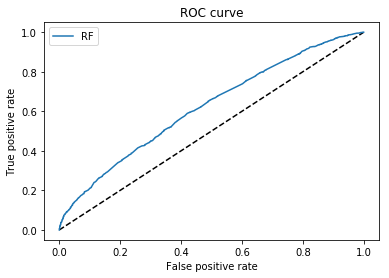

In [151]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Validation Metrics

              precision    recall  f1-score   support

           0       0.62      0.98      0.76       594
           1       0.36      0.02      0.04       356

   micro avg       0.62      0.62      0.62       950
   macro avg       0.49      0.50      0.40       950
weighted avg       0.53      0.62      0.49       950

Confusion Matrix
[[580  14]
 [348   8]]

Accuracy
0.6189473684210526


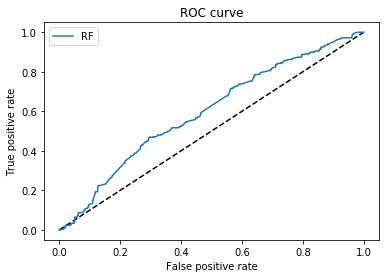

In [152]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [153]:
print(X_validate.index.min())
print(X_validate.index.max())

2016-01-20 08:18:27.984000
2017-12-04 15:45:10.747000


In [154]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2016-01-20 14:42:03.869000')
end = primary_forecast.index.get_loc('2017-12-04 15:45:10.747000') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       594
           1       0.37      1.00      0.54       350

   micro avg       0.37      0.37      0.37       944
   macro avg       0.19      0.50      0.27       944
weighted avg       0.14      0.37      0.20       944

Confusion Matrix
[[  0 594]
 [  0 350]]

Accuracy
0.3707627118644068


/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


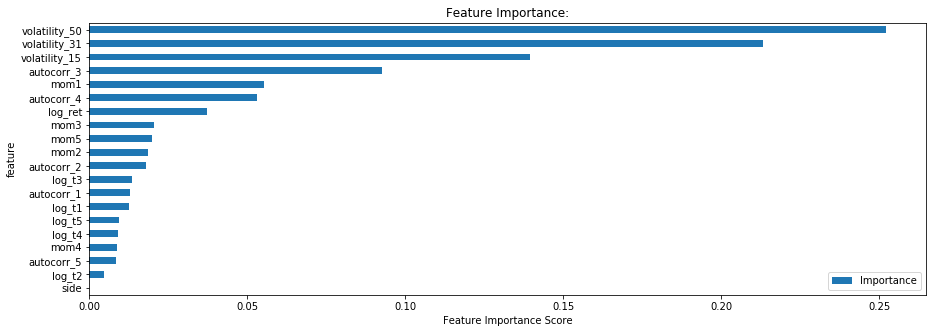

In [155]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

---
## Performance Tear Sheets (In-sample)

### Without Meta Labeling

In [156]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [157]:
valid_dates = X_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [158]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [159]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

Start date,2016-01-21
End date,2017-12-04
Total months,23
,Backtest
Annual return,-17.3%
Cumulative returns,-30.8%
Annual volatility,61.2%
Sharpe ratio,-0.02
Calmar ratio,-0.28
Stability,0.75
Max drawdown,-61.0%


### With Meta Labeling

In [160]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [161]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/empyrical/stats.py:1511: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2016-01-21
End date,2017-12-04
Total months,23
,Backtest
Annual return,-3.7%
Cumulative returns,-7.0%
Annual volatility,10.6%
Sharpe ratio,-0.30
Calmar ratio,-0.26
Stability,0.69
Max drawdown,-13.9%


---
## Perform out-of-sample test
### Meta Model Metrics

In [162]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2018-01-02':]
y_oos = y['2018-01-02':]

              precision    recall  f1-score   support

           0       0.52      0.99      0.68      1085
           1       0.64      0.03      0.06      1003

   micro avg       0.53      0.53      0.53      2088
   macro avg       0.58      0.51      0.37      2088
weighted avg       0.58      0.53      0.38      2088

Confusion Matrix
[[1069   16]
 [ 974   29]]

Accuracy
0.5258620689655172


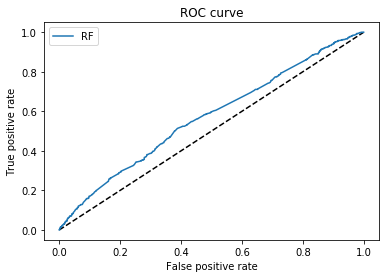

In [163]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [164]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2018-01-02':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1085
           1       0.48      1.00      0.65      1003

   micro avg       0.48      0.48      0.48      2088
   macro avg       0.24      0.50      0.32      2088
weighted avg       0.23      0.48      0.31      2088

Confusion Matrix
[[   0 1085]
 [   0 1003]]

Accuracy
0.4803639846743295


/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Primary Model (Test Data)

In [165]:
test_dates = X_oos.index

# Downsample to daily
prim_rets_test = labels.loc[test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets_prim, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets_prim)

Start date,2018-01-18
End date,2019-01-31
Total months,12
,Backtest
Annual return,288.7%
Cumulative returns,330.6%
Annual volatility,120.8%
Sharpe ratio,1.62
Calmar ratio,4.68
Stability,0.00
Max drawdown,-61.7%


## Meta Model (Test Data)

/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/empyrical/stats.py:1511: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2018-01-18
End date,2019-01-31
Total months,12
,Backtest
Annual return,0.1%
Cumulative returns,0.1%
Annual volatility,7.9%
Sharpe ratio,0.06
Calmar ratio,0.02
Stability,0.08
Max drawdown,-5.1%


/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.15,2018-02-05,2018-02-06,2018-12-26,233
1,3.34,2019-01-03,2019-01-04,NaT,NaN
2,0.00,2018-01-18,2018-01-18,2018-01-18,1
3,0.00,2018-01-18,2018-01-18,2018-01-18,1
4,0.00,2018-01-18,2018-01-18,2018-01-18,1


/home/jackal08/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


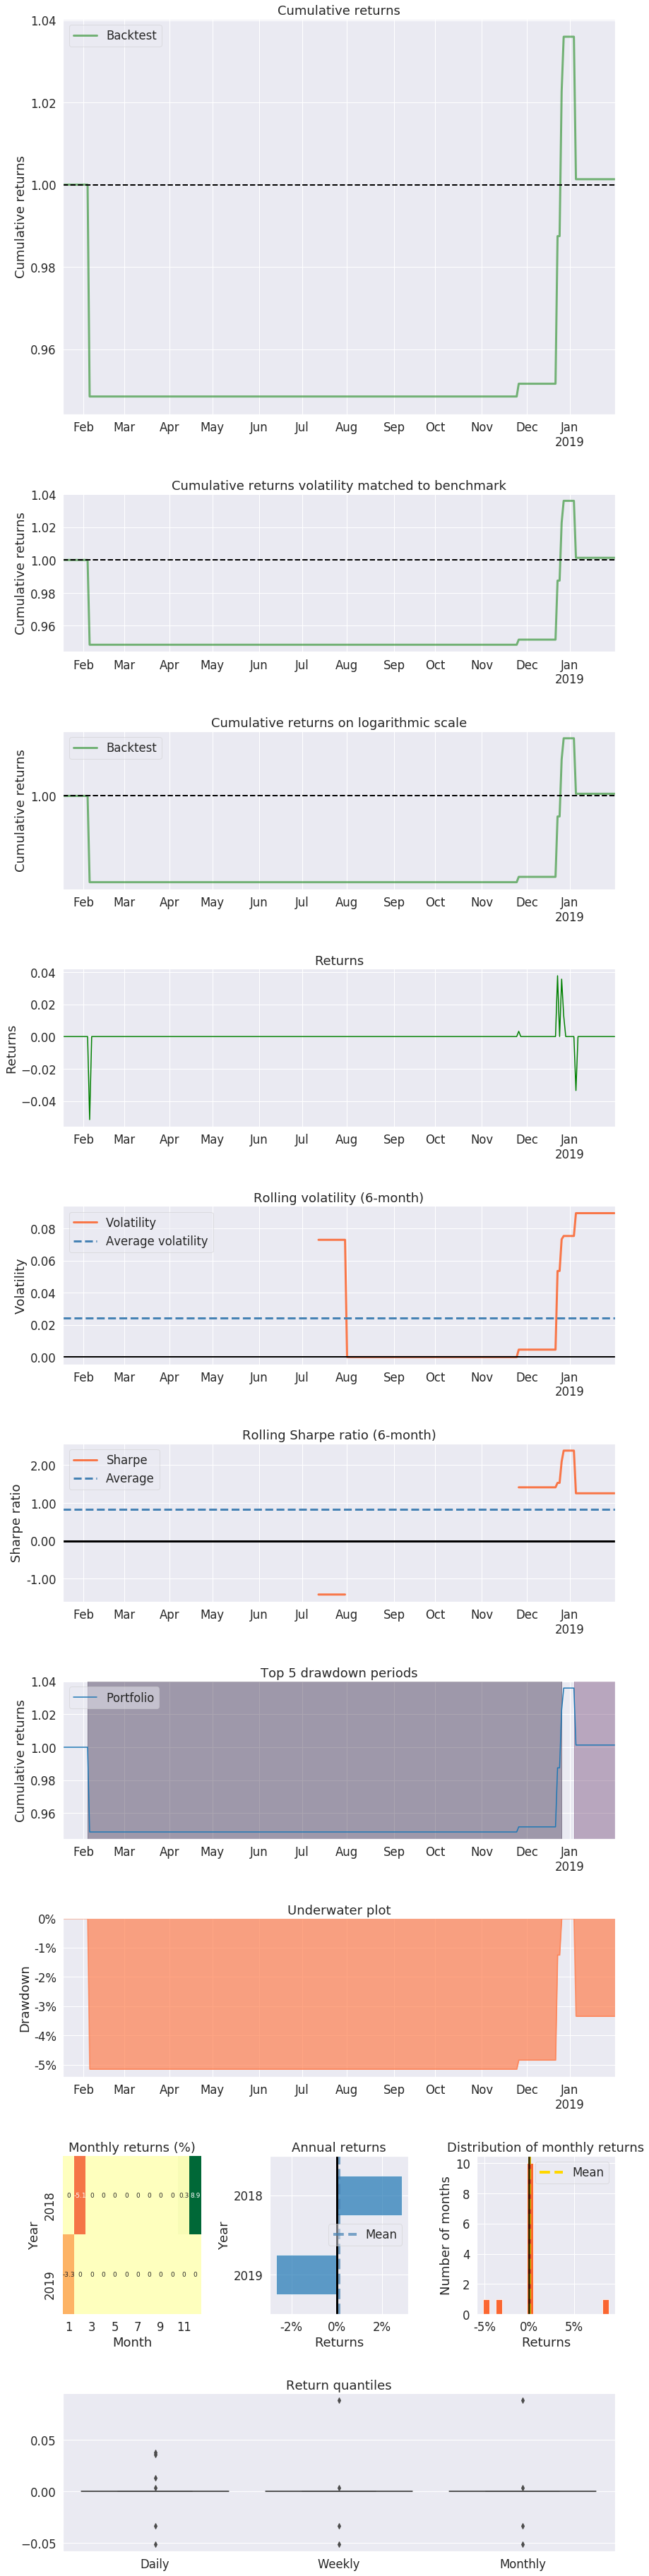

In [166]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)